<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [78]:
import os
import pandas as pd
from tqdm.auto import tqdm

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [ ]:
import transformers
from datasets import load_dataset
import evaluate

c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import matplotlib.ticker as ticker
# from transformers import get_scheduler
# import matplotlib.pyplot as plt

# import numpy as np

# import random
# import math
# import time
# import string
# import pymorphy3
# import re

# # datasets from huggingface
# from datasets import load_dataset
# from transformers import BertTokenizer, BertModel

# from nltk.corpus import stopwords
# import nltk

# from tqdm.notebook import tqdm
# from torch.utils.tensorboard import SummaryWriter
# import matplotlib.pyplot as plt

# import os
# from datetime import datetime
# from torch.nn.utils.rnn import pad_sequence

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import BertTokenizer, BertModel

In [14]:
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding, DataCollatorWithPadding, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

'cuda'

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [117]:
### This is just an interface example. You may change it if you want.

# Быстрый класс для тюнинга (без attention карт)
class TrainerClassificationModel(nn.Module):
    def __init__(self, bert_model_name: str, device, cnt_class=4):
        # YOUR CODE: create additional layers for classfication
        # self.backbone = #...
        super().__init__()
        self.device = device
        self.cnt_class = cnt_class
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, 
                                                                        attn_implementation="sdpa", 
                                                                        num_labels=self.cnt_class).to(self.device)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, **batch):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        # batch.pop("num_items_in_batch", None)
        out = self.model(**batch)  # SequenceClassifierOutput
        return out
        
    # def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    #     return self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)

# Медленный класс для анализа (с attention картами)
class AttentionModel(nn.Module):
    def __init__(self, model_name: str, device, cnt_class=4):
        super().__init__()
        self.device = device
        self.cnt_class = cnt_class
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=self.cnt_class,
            attn_implementation="eager",    
        ).to(self.device)

        self.model.eval()

        self.model.config.return_dict = True
        self.model.config.output_attentions = True
        # self.model.config.output_hidden_states = False
        self.last_attentions = None        

    def forward(self, **batch):
        out = self.model(**batch)
        self.last_attentions = out.attentions  # tuple[layer] -> (batch, heads, seq_l, seq_l)
        # return out.attentions
        return {"logits": out.logits, "attentions": out.attentions}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [34]:
def freeze_backbone_function(model: TrainerClassificationModel):
    # Заморозим все слои, кроме классификатора
    for w in model.model.bert.parameters():
        w.requires_grad = False
    for w in model.model.classifier.parameters():
        w.requires_grad = True

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

Вначале надо создать класс датасет и даталоадер для обоих файлов

In [46]:
rudata = pd.read_excel('data_problems.xlsx', usecols=[1,2])
endata = pd.read_excel('data_problems_translated.xlsx', usecols=[1,2])

In [48]:
codes, uniques = pd.factorize(rudata['Тема'], sort=True)  # sort=False — по порядку появления
rudata['class_id'] = codes
# Словарь соответствий:
ru_mapping = {cat: i for i, cat in enumerate(uniques)}

codes, uniques = pd.factorize(endata['topic'], sort=True)  # sort=False — по порядку появления
endata['class_id'] = codes
# Словарь соответствий:
en_mapping = {cat: i for i, cat in enumerate(uniques)}

In [53]:
X = rudata['Задача']
y = rudata['class_id']
ru_X_train, ru_X_test, ru_y_train, ru_y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

X = endata['problem_text']
y = endata['class_id']
en_X_train, en_X_test, en_y_train, en_y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

In [54]:
MODEL_NAME = 'cointegrated/rubert-tiny2'
rubert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(ru_mapping))

MODEL_NAME = 'tbs17/MathBert'
mathbert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(en_mapping))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
ru_tokenizer = rubert_tiny_transformer_model.tokenizer
en_tokenizer = mathbert_tiny_transformer_model.tokenizer

class TextClassificationDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length=1024):
        self.X = X.tolist()  
        self.y = y.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = int(self.y[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
        )
        enc["labels"] = label
        return enc
    
    # def text_to_tokens_ids(self, text):
    #     tokens = self.tokenizer.tokenize(text)
    #     return torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens)).to(device)

ru_train_ds = TextClassificationDataset(ru_X_train, ru_y_train, ru_tokenizer, max_length=1024)
ru_test_ds = TextClassificationDataset(ru_X_test, ru_y_test, ru_tokenizer, max_length=1024)

en_train_ds = TextClassificationDataset(en_X_train, en_y_train, en_tokenizer, max_length=1024)
en_test_ds = TextClassificationDataset(en_X_test, en_y_test, en_tokenizer, max_length=1024)

## Если хотим обучать через готовый трейнер

In [ ]:
# # Метрики (accuracy + macro-F1)
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)
#     return {
#         "accuracy": accuracy_score(labels, preds),
#         "f1_macro": f1_score(labels, preds, average="macro"),
#     }

In [137]:
rudata = pd.read_excel('data_problems.xlsx', usecols=[1,2])
rudata.head(2)

,Задача,Тема
0,Между девятью планетами Солнечной системы введ...,Графы
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы


In [138]:
codes, uniques = pd.factorize(rudata['Тема'], sort=True)  # sort=False — по порядку появления
rudata['class_id'] = codes
# Словарь соответствий:
mapping = {cat: i for i, cat in enumerate(uniques)}
mapping

{'Геометрия': 0,
 'Графы': 1,
 'Дирихле': 2,
 'Инвариант': 3,
 'Комбинаторика': 4,
 'Многочлен': 5,
 'Теория чисел': 6}

In [139]:
# billsum = billsum.train_test_split(test_size=0.1)
X = rudata['Задача']
y = rudata['class_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

In [87]:
# def preprocess_function(X, y):
#     # Токенизация входного предложения
#     model_inputs = tokenizer(X.tolist(), max_length=1024, truncation=True)
#     # Добавляем к словарю с input_ids входа новый ключ с target_ids выхода
#     model_inputs["labels"] = y.tolist()
#     return model_inputs

#  return_tensors="pt" 
# model_inputs = preprocess_function(X_train, y_train)

In [140]:
MODEL_NAME = 'cointegrated/rubert-tiny2'

In [141]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextClassificationDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length=1024):
        self.X = X.tolist()  
        self.y = y.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = int(self.y[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
        )
        enc["labels"] = label
        return enc
    
    # def text_to_tokens_ids(self, text):
    #     tokens = self.tokenizer.tokenize(text)
    #     return torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens)).to(device)

train_ds = TextClassificationDataset(X_train, y_train, tokenizer, max_length=1024)
test_ds = TextClassificationDataset(X_test, y_test, tokenizer, max_length=1024)

Если хотим кастомно обучать без трейнера хагинг фейс

In [142]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

# for batch in train_loader:
#     print(batch)
#     # batch = {k: v.to(device) for k, v in batch.items()}
#     # model.to(device)
#     break
#     # outputs = model(**batch)
#     # loss = outputs.loss
#     # loss.backward()

In [143]:
# Метрики (accuracy + macro-F1)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [144]:
# def train_transformer(model, train_ds, test_ds, freeze_backbone=True):
#     if freeze_backbone:
#         model = freeze_backbone_function(model)

#     # Динамический паддинг
#     data_collator = DataCollatorWithPadding(tokenizer=ru_tokenizer, return_tensors="pt")

#     training_args = TrainingArguments(

#         output_dir="./results",
#         logging_dir="./logs",

#         learning_rate=2e-5,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         weight_decay=0.01,
#         num_train_epochs=10,
#         save_total_limit=3,

#         eval_strategy="steps",
#         eval_steps=50,
#         save_strategy="steps",
#         save_steps=50,           
#         load_best_model_at_end=True,
#         metric_for_best_model="accuracy",
#         greater_is_better=True,
#         logging_steps=50,           # как часто логировать train loss/lr
#         logging_strategy="steps",   # или "epoch"
#         # report_to=["tensorboard"],  # включить TB
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_ds,
#         eval_dataset=test_ds,
#         processing_class=ru_tokenizer,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics
#     )
    
#     # Не передавать loss-kwargs (в т.ч. num_items_in_batch) в model.forward
#     trainer.model_accepts_loss_kwargs = False

#     trainer.label_names = ["labels"]

#     trainer.train()
#     best_model = trainer.model       

#     return best_model


# rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, ru_train_ds, ru_test_ds, freeze_backbone=True)

In [ ]:
# from sklearn.metrics import classification_report
# from tqdm.auto import tqdm

# # # получить предсказания и лейблы
# # preds_output = trainer.predict(test_ds)

# # # logits → классы
# # preds = np.argmax(preds_output.predictions, axis=-1)
# # labels = preds_output.label_ids

# rubert_tiny_finetuned_with_freezed_backbone.eval()
# all_preds, all_labels = [], []
# device = next(rubert_tiny_finetuned_with_freezed_backbone.parameters()).device

# for batch in tqdm(test_loader):
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = rubert_tiny_finetuned_with_freezed_backbone(**batch)
#         preds = outputs.logits.argmax(dim=-1).cpu().numpy()
#         labels = batch["labels"].cpu().numpy()
#         all_preds.extend(preds)
#         all_labels.extend(labels)


# print(classification_report(all_labels, all_preds, target_names=mapping.keys()))

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

## Если хотим кастомно обучать без трейнера хагинг фейс

In [ ]:
ru_collate_fn = DataCollatorWithPadding(tokenizer=ru_tokenizer, return_tensors="pt")
en_collate_fn = DataCollatorWithPadding(tokenizer=en_tokenizer, return_tensors="pt")

BATCH_SIZE = 16

ru_train_loader = DataLoader(
    ru_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=ru_collate_fn,
    num_workers=0,
    pin_memory=True
)

ru_test_loader = DataLoader(
    ru_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=ru_collate_fn,
    num_workers=0,
    pin_memory=True
)


en_train_loader = DataLoader(
    en_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=en_collate_fn,
    num_workers=0,
    pin_memory=True
)

en_test_loader = DataLoader(
    en_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=en_collate_fn,
    num_workers=0,
    pin_memory=True
)

In [ ]:
LR = 1e-4
NUM_EPOCHS = 3

In [80]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
def train_model(model, num_epoch, train_loader, test_loader, model_name, freeze_backbone=True):
    
    if freeze_backbone:
        model = freeze_backbone_function(model)

    # sanity-check:
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable} / {total}")

    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=LR)

    num_batches_per_epoch = len(train_loader)  
    num_training_steps = num_epoch * num_batches_per_epoch  
    num_warmup_steps = int(0.1 * num_training_steps) 

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,       
        num_training_steps=num_training_steps,   
)

    # lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

    best_loss = float('inf') 
    best_model_wts = None
    history = dict(train_loss=[], val_loss=[], val_acc=[], val_f1_macro=[])

    for epoch in range(num_epoch):
        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            # model.to(device)
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            # loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        # ---------- EVAL ----------
        model.eval()
        val_running = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = criterion(outputs.logits, batch['labels'])
                val_running += loss.item()

                preds = outputs.logits.argmax(dim=-1)
                y_pred.append(preds.cpu().numpy())
                y_true.append(batch['labels'].cpu().numpy())

            val_loss = val_running / len(test_loader)
                    
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)

            val_acc = accuracy_score(y_true, y_pred)
            f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
            # f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1_macro'].append(f1_macro)
            # history['val_f1_weighted'].append(f1_weighted)

            # save best by val_loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = model.state_dict()

                model_path = os.path.join('models', f"{model_name}.pth")
                torch.save(best_model_wts, model_path)

    return history, model, y_true, y_pred

In [93]:
history, model, y_true, y_pred = train_model(
    rubert_tiny_transformer_model,
    NUM_EPOCHS,
    ru_train_loader,
    ru_test_loader,
    'ru_freeze',
    freeze_backbone=True,
)

trainable params: 2191 / 29195959


  0%|          | 0/297 [00:00<?, ?it/s]/opt/anaconda3/envs/LLM/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/297 [00:00<?, ?it/s]/opt/anaconda3/envs/LLM/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 297/297 [00:27<00:00, 10.79it/s]


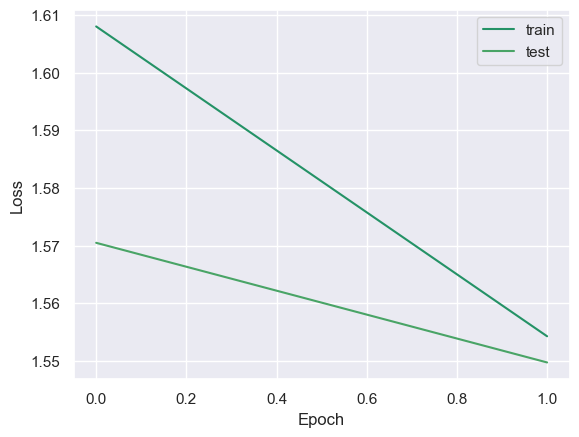

In [96]:
import matplotlib.pyplot as plt
ax = plt.figure().gca()
ax.plot(history['train_loss'])
ax.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
'train', 
'test'
            ])

In [99]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        43
           1     0.3333    0.0256    0.0476        39
           2     0.0000    0.0000    0.0000        50
           3     0.0000    0.0000    0.0000        23
           4     0.4706    0.1758    0.2560        91
           5     0.0000    0.0000    0.0000        45
           6     0.4694    0.9705    0.6327       237

    accuracy                         0.4678       528
   macro avg     0.1819    0.1674    0.1338       528
weighted avg     0.3164    0.4678    0.3317       528



In [ ]:
history, model, y_true, y_pred = train_model(
    rubert_tiny_transformer_model,
    NUM_EPOCHS,
    ru_train_loader,
    ru_test_loader,
    'ru_freeze',
    freeze_backbone=False,
)

In [ ]:
ax = plt.figure().gca()
ax.plot(history['train_loss'])
ax.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
'train', 
'test'
            ])

In [ ]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [157]:
import matplotlib.ticker as ticker

In [ ]:
def get_attention_fig(text: str, attention_layer, model: AttentionModel, n_heads = 4, n_rows = 2, n_cols = 2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(12 * n_cols, 12 * n_rows))

    enc = model.tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
    ticks = model.tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    with torch.no_grad():
        out = model(**enc)
    attns  = out["attentions"]    
    att_first = attns[attention_layer][0]  
    logits = out["logits"]   

    print(f"Predicted class: {list(ru_mapping.keys())[np.argmax(logits.cpu(), axis=-1)]}") 

    L = att_first.shape[-1]
    assert L == len(ticks), f"len(tokens)={len(ticks)} != L={L}"  

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = att_first[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='magma')

        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.grid(False)

        ax.set_title(f'Head {i+1}', size=22)
        ax.set_xlabel("key", size=19)
        ax.set_ylabel("query", size=19)
        ax.tick_params(labelsize=15)

        # позиции тиков
        positions = np.arange(L)
        ax.set_xticks(positions)
        ax.set_yticks(positions)

        # подписи
        ax.set_xticklabels(ticks,
                           rotation=90
                           )
        ax.set_yticklabels(ticks)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_label_position('bottom')

        fig.tight_layout()

    return fig.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
insp = AttentionModel('cointegrated/rubert-tiny2', device, len(ru_mapping)).eval()

In [ ]:
text = 'Геометрия - это раздел математики, изучающий свойства и отношения точек, линий, поверхностей и фигур в пространстве.'
get_attention_fig(text, attention_layer=0, model=insp, n_heads=4, n_rows=2, n_cols=2)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [ ]:
# загрузка
insp = AttentionModel('cointegrated/rubert-tiny2', device, len(ru_mapping)).eval()
insp.load_state_dict(torch.load("models/ru_freeze.pth", map_location=insp.device), strict=True)

Predicted class: Комбинаторика


/var/folders/yr/s_88h1jx275_s5hfylyqqmxc0000gn/T/ipykernel_4239/3573221025.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


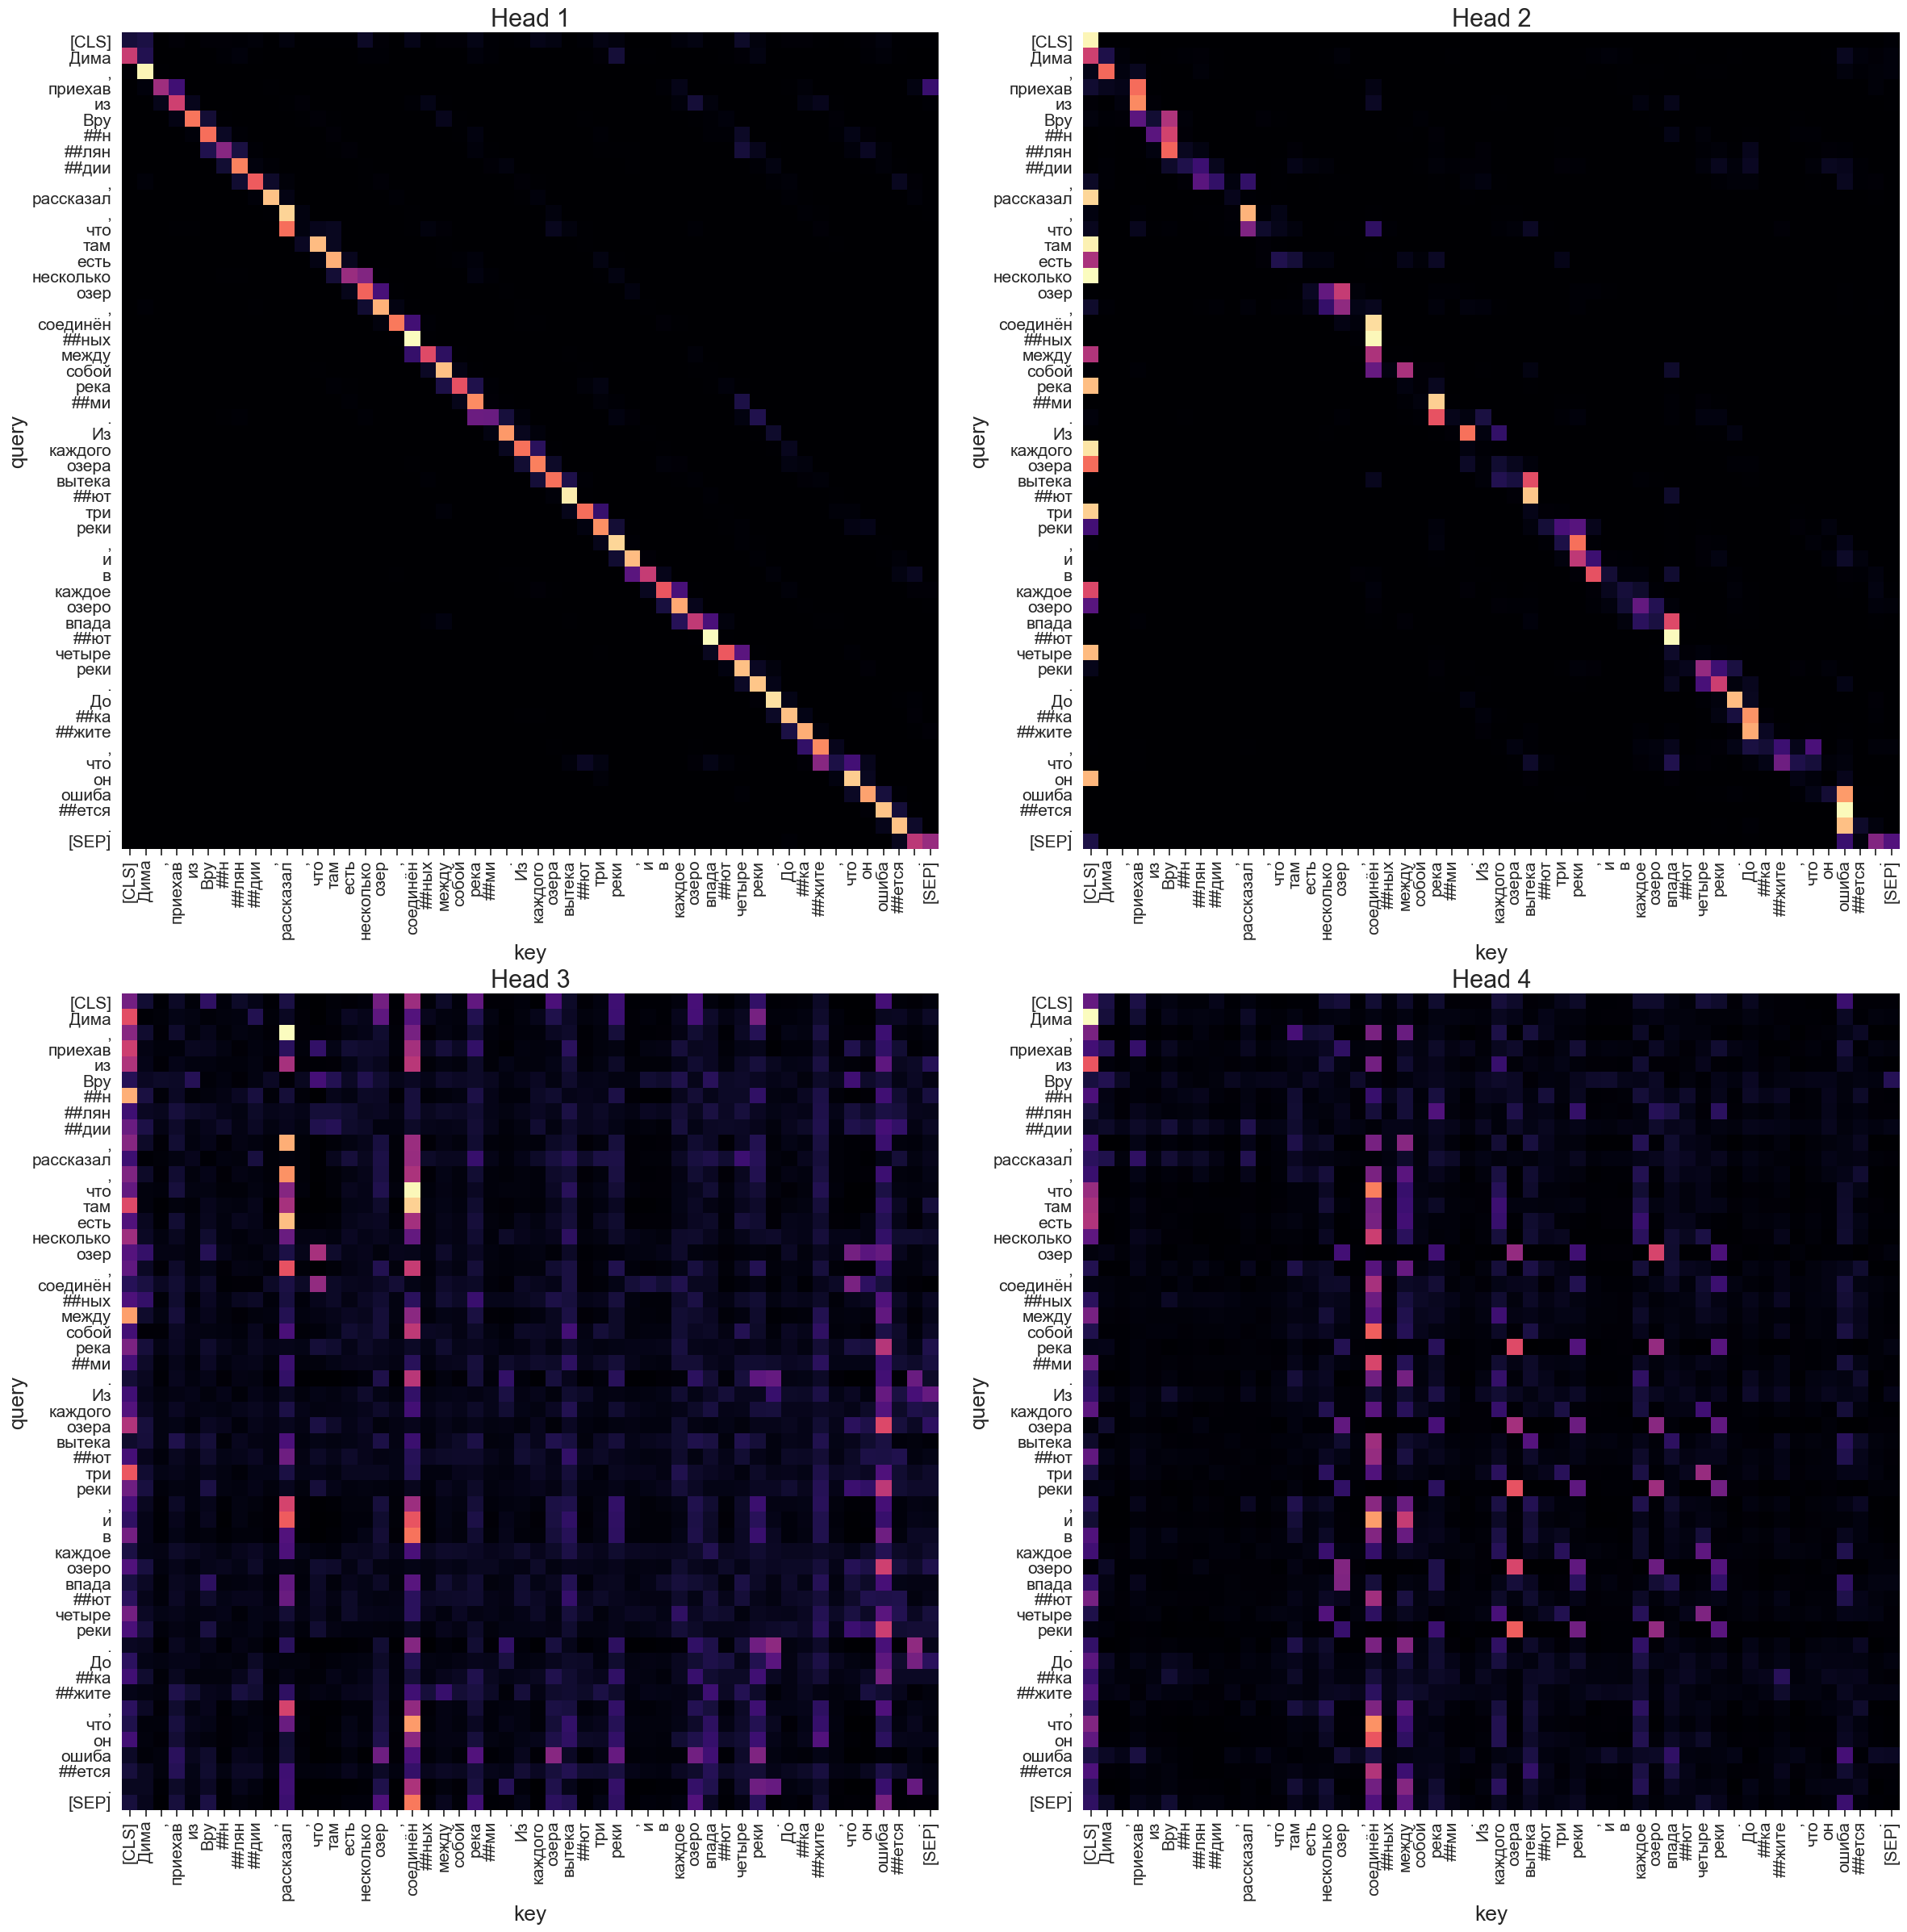

In [251]:
text = ru_X_test.to_list()[0]
get_attention_fig(text, attention_layer=0, model=insp, n_heads=4, n_rows=2, n_cols=2)